# _In-Silico_ Solvent Optimization Study

This is a test problem to compare how optimization with black-box algorithms does vs. with molecular descriptors.

You should describe the kinetic model used to generate experimental data and the nature of the pareto front.

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
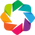

In [7]:
from surrogate_model_functions import plot_3d_model, loo_error
from solvent_optimization import (descriptors_optimization, Experiments, create_pcs_ds, create_domain,
                                  generate_initial_experiment_data,
                                  fullfact, calculate_effects)
from summit.strategies import _pareto_front
from summit.data import DataSet, solvent_ds

import pandas as pd
import hvplot.pandas
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import FTestAnovaPower
import holoviews as hv
hv.extension('bokeh')
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from math import log

import json

## 1. Tuning Kinetic Model

In [11]:
#Solvent Dataset compressed to 3 principal components
solvent_ds_pcs, pca = create_pcs_ds(num_components=3, ucb_filter=True, verbose=True)

80 solvents for optimization
70.0% of variance is explained by 3 principal components.


In [12]:
pd.DataFrame(pca.components_.T, 
             index=solvent_ds.data_columns + ['solubility'], 
             columns=solvent_ds_pcs.data_columns).sort_values('PC_1')

,PC_1,PC_2,PC_3
partition_coefficient,-0.350498,-0.012300,0.252559
sigma_2,-0.316189,0.267132,0.074034
molar_volume,-0.295616,0.276469,0.047847
molecular_refractive_power,-0.273993,0.325531,0.106905
molecular_weight,-0.163227,0.390747,0.067756
vapour_pressure,-0.087970,-0.242292,-0.066203
refractive_index,-0.032506,0.205296,0.202902
boiling_point,0.135144,0.408971,0.104810
sigma_5,0.153697,0.300914,-0.261709
viscosity,0.156539,0.147958,0.441249


* t<sub>1</sub> is highly correlated with measures of polarity such as partition coefficient, dielctric constant and dipole moment. Negative t<sub>1</sub> values indicate higher polarity (e.g., water has the most negative t<sub>1</sub> value at -7.736), and positive values indicate less polarity (all the alkanes have postive t<sub>1</sub> values).  The polarity hypothesis is further confirmed by the correlation between t<sub>1</sub> and the solubility of potassium hydroxide in the solvent; smaller solubilities would indicate lower polarity and therefore higher partition coefficient. Therefore, partition coefficient has a positive load on t<sub>1</sub> and solubility has a negative load on t<sub>1</sub>. 
* t<sub>2</sub> is highly correlated with measures van der waals forces such as boiling point, molecular weight, and molar refractive power (measure of polarizability or ability to form instantaneous dipoles).
* t<sub>3</sub>  is roughly a measure of hydrogen bonding.  It is correlated with density and the $\sigma_1$ and $\sigma_3$ parameters of the COSMO-RS charge density plots.
* is similar to a measure of acidity. This is because of its strong correlation with the electronic basicity and acidity regions of the sigma parameters. 

In [15]:
#Static plot
# fig, ax = plt.subplots()
# le = LabelEncoder() #Label encoder for the different solvent classes
# solvent_classes = solvent_ds_pcs['solvent_class']
# labels = le.fit_transform(solvent_classes)
# pcs = solvent_ds_pcs.data_to_numpy()
# markers = ['^', 'P', 'x', 'v', 'p', 'o', 's', '>', 'D', '<', '*']
# for i, solvent_class in enumerate(le.classes_):
#     ix = np.where(solvent_classes==solvent_class)[0]
#     mask = np.ones(len(ix), dtype=bool)
#     ax.scatter(pcs[ix, 0], pcs[ix, 1], c='k', marker=markers[i], label=solvent_class)
# ax.legend(bbox_to_anchor=(1, 1.0))
# ax.spines['left'].set_position('zero')
# ax.spines['right'].set_color('none')
# ax.spines['bottom'].set_position('zero')
# ax.spines['top'].set_color('none')

#Interactive plot of the first two principal components
solvent_ds_pcs.droplevel('TYPE', axis=1). \
               hvplot(x='PC_1', y='PC_2',
                      kind='scatter',
                      hover_cols=['stenutz_name', 'PC_1'])

:Scatter   [PC_1]   (PC_2,stenutz_name,PC_1)

I want the reaction to work best in dipolar aprotic solvents in general. This means that solvents sort of in the first quadrant.  I also choose to make it such that nonpolar alkanes will give good conversion but not good stereoselectivity. 

In [ ]:
solvent_ds_pcs.loc['67-68-5']

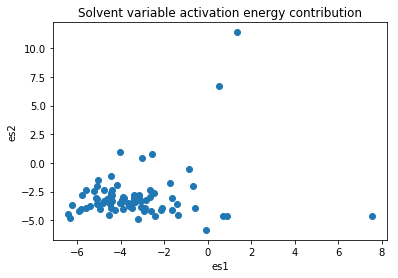

In [16]:
Es1 = lambda pc1, pc2, pc3: -np.log(abs((pc2+0.73*pc1-4.46)*(pc2+2.105*pc1+11.367)))+ pc3
Es2 = lambda pc1, pc2, pc3: -2*np.log(abs((pc2+0.73*pc1-4.46))) - 0.2*pc3**2
pcs = solvent_ds_pcs.data_to_numpy()
pcs = pcs.astype(np.float64)
es1=Es1(pcs[:, 0], pcs[:, 1], pcs[:, 2])
es2=Es2(pcs[:, 0], pcs[:, 1], pcs[:, 2])
plt.figure()
plt.scatter(es1, es2)
plt.xlabel('es1'); plt.ylabel('es2')
_ = plt.title('Solvent variable activation energy contribution')

 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning:invalid value encountered in true_divide


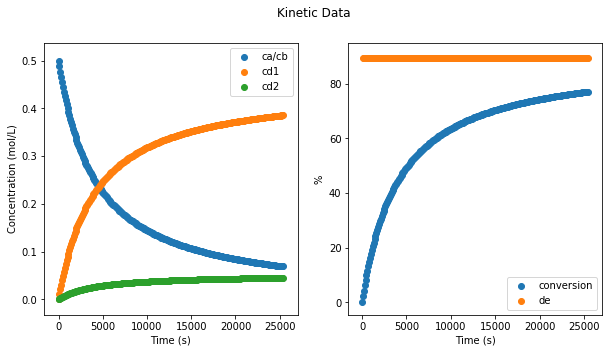

In [17]:
#Now let's test running an "experiment" with one solvent
random_state = np.random.RandomState(100)
exp = Experiments(solvent_ds_pcs, random_state)
x = exp._integrate_rate('616-38-6', t=25200, step_size=100)

fig, axes = plt.subplots(1, 2, figsize=(10,5))
trange = np.linspace(0, 25400, x.shape[0])
cd1 = x[:, 0]
cd2 = x[:, 1]

axes[0].scatter(trange, 0.5-x[:,0]-x[:,1], label='ca/cb')
axes[0].scatter(trange, cd1, label='cd1')
axes[0].scatter(trange, cd2, label='cd2')
axes[0].legend(); axes[0].set_xlabel('Time (s)');
axes[0].set_ylabel('Concentration (mol/L)')

axes[1].scatter(trange, cd1/0.5*100, label='conversion')
axes[1].scatter(trange, cd1/(cd1+cd2)*100, label='de')
axes[1].legend(); axes[1].set_xlabel('Time (s)');
axes[1].set_ylabel('%')
_ = fig.suptitle('Kinetic Data')

 /Users/Kobi/Documents/Research/summit/case_studies/in_silico_studies/solvent_optimization.py:126: RuntimeWarning:invalid value encountered in true_divide


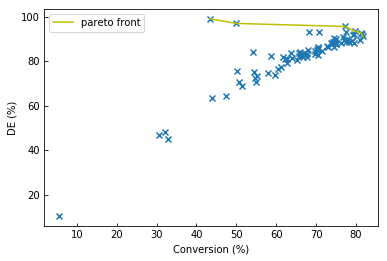

In [18]:
#Calculate conversion and de for all solvents
random_state = np.random.RandomState(1000)
exp = Experiments(solvent_ds_pcs, random_state)
all_experiments = [exp.run(cas) 
                   for cas in solvent_ds_pcs.index.values]
all_experiments = np.array(all_experiments)
pareto, pareto_indices = _pareto_front(all_experiments)
ax = plt.subplot(111)
ax.set_xlabel('Conversion (%)'); ax.set_ylabel('DE (%)')
ax.scatter(all_experiments[:, 0], all_experiments[:, 1], marker='x')
ax.plot(pareto[:, 0], pareto[:, 1], c='y', label='pareto front')
ax.legend()
ax.tick_params(direction='in')
plt.savefig('outputs/in_silico_experiment_space.png')
plt.savefig('outputs/in_silico_experiment_space.svg')

In [19]:
#Dsiplay pareto front solvents
solvents_pareto = solvent_ds_pcs.iloc[pareto_indices, :]
solvents_pareto

,stenutz_name,cosmo_name,chemical_formula,solvent_class,solvent_name,PC_1,PC_2,PC_3
cas_number,,,,,,,,
75-05-8,acetonitrile,acetonitrile,C2H3N,Dipolar aprotic,Acetonitrile,3.147142,-2.122233,-2.006489
68-12-2,"N,N-dimethylformamide",dimethylformamide,C3H7NO,Dipolar aprotic,Dimethyl formamide (DMF),2.014189,0.364211,-2.043380
126-33-0,sulfolane,"tetrahydrothiophene-1,1-dioxide",C4H8O2S,Dipolar aprotic,Sulfolane,3.885026,4.210762,-1.483849
96-49-1,"1,3-dioxolan-2-one","1,3-dioxolan-2-one",C3H4O3,Dipolar aprotic,Ethylene carbonate,5.476348,2.278569,-1.197862
108-32-7,"4-methyl-2-oxo-1,3-dioxolane",propylenecarbonate,C4H6O3,Dipolar aprotic,Propylene carbonate,3.426115,2.421599,-1.770695
680-31-9,hexamethylphosphoramide,hexamethylphosphoramide,C6H18N3OP,Dipolar aprotic,Hexamethyl phosphoramidite (HMPA),-1.225801,5.389174,-0.200501
67-68-5,dimethyl sulfoxide,dimethylsulfoxide,C2H6OS,Dipolar aprotic,Dimethyl sulfoxide (DMSO),3.927690,1.590086,-1.508395


In [20]:
num_initial_experiments=8
batch_size=4
num_components=3
num_batches=(40-num_initial_experiments)// batch_size + 1
res =  descriptors_optimization(batch_size=batch_size,
                                num_batches=num_batches,
                                num_intial_experiments=num_initial_experiments,
                                num_components = num_components,
                                random_seed=100,
                                normalize_inputs=True,
                                normalize_outputs=False,
                                design_criterion='center',
                                random_rate=0.2,
                                save_to_disk=False)

 /Users/Kobi/Documents/Research/summit/case_studies/in_silico_studies/solvent_optimization.py:126: RuntimeWarning:invalid value encountered in true_divide


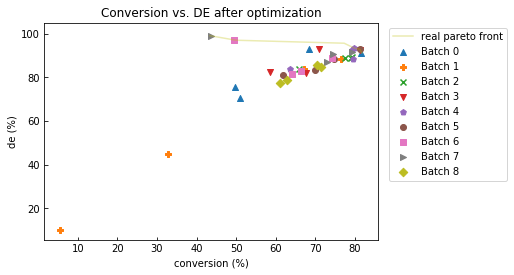

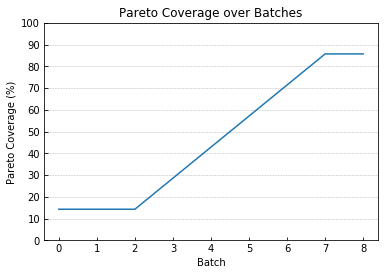

In [21]:
#Visualize the optimization data
experiments = res.experiments
plt.figure()
ax = plt.subplot(111)
ax.tick_params(direction='in')
markers = ['^', 'P', 'x', 'v', 'p', 'o', 's', '>', 'D', '*']
for i in range(num_batches): 
    data = experiments[experiments['batch']==float(i)].data_to_numpy()
    ax.scatter(data[:, 0], data[:, 1], marker=markers[i],label=f"Batch {i}")
# ax.scatter(all_experiments[:, 0], all_experiments[:, 1], marker='<', alpha=0.1, label='all data')
ax.plot(pareto[:, 0], pareto[:, 1], c='y', label='real pareto front', alpha=0.3)
leg = ax.legend(bbox_to_anchor=(1.4, 1))
plt.xlabel('conversion (%)'); plt.ylabel('de (%)')
plt.savefig('outputs/solvent_optimization_molecular_descriptors.png',bbox_extra_artists=(leg,), bbox_inches='tight')
plt.savefig('outputs/solvent_optimization_molecular_descriptors.svg',bbox_extra_artists=(leg,), bbox_inches='tight')
plt.title('Conversion vs. DE after optimization')

coverages = np.zeros(num_batches)
pareto_size = solvents_pareto.shape[0]
for i in range(num_batches):
    batches = experiments[experiments['batch']<= i]
    check = np.intersect1d(solvents_pareto.index.values, batches['solvent'].values)
    coverages[i] = len(check)/pareto_size*100
plt.figure()
ax = plt.subplot(111)
ax.tick_params(direction='in')
ax.plot(np.arange(0, num_batches, 1, dtype=int), coverages)
ax.set_xticks(np.arange(0, num_batches, 1, dtype=int),minor=False)
ax.set_yticks(np.arange(0, 110, 10, dtype=int),minor=False)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
ax.set_xlabel('Batch'); ax.set_ylabel('Pareto Coverage (%)')
plt.savefig('outputs/solvent_optimization_coverage_molecular_descriptors.png', bbox_inches='tight')
plt.savefig('outputs/solvent_optimization_coverage_molecular_descriptors.svg', bbox_inches='tight')
_ = ax.set_title('Pareto Coverage over Batches')

In [22]:
outputs = experiments.data_to_numpy()[:, 0:2]
outputs = outputs.astype(np.float64)
optimization_pareto, optimization_pareto_indices = _pareto_front(outputs)
optimization_pareto_cas = experiments.iloc[optimization_pareto_indices]['solvent']
optimization_pareto_df = solvent_ds_pcs.loc[optimization_pareto_cas]
optimization_pareto_df = optimization_pareto_df[['PC_1', 'PC_2', 'PC_3', 'solvent_name', 'solvent_class']]
optimization_pareto_df['conversion'] = optimization_pareto[:, 0]
optimization_pareto_df['de'] = optimization_pareto[:, 1]
optimization_pareto_df.to_csv('outputs/solvent_optimization_pareto.csv')
optimization_pareto_df

,PC_1,PC_2,PC_3,solvent_name,solvent_class,conversion,de
cas_number,,,,,,,
75-05-8,3.147142,-2.122233,-2.006489,Acetonitrile,Dipolar aprotic,81.648670,91.072013
126-33-0,3.885026,4.210762,-1.483849,Sulfolane,Dipolar aprotic,81.340300,92.771324
96-49-1,5.476348,2.278569,-1.197862,Ethylene carbonate,Dipolar aprotic,79.855529,93.323434
680-31-9,-1.225801,5.389174,-0.200501,Hexamethyl phosphoramidite (HMPA),Dipolar aprotic,49.359786,96.941978
67-68-5,3.927690,1.590086,-1.508395,Dimethyl sulfoxide (DMSO),Dipolar aprotic,43.740994,99.025831


In [23]:
optimization_pareto_df.columns

MultiIndex(levels=[['PC_1', 'PC_2', 'PC_3', 'chemical_formula', 'cosmo_name', 'solvent_class', 'solvent_name', 'stenutz_name', 'conversion', 'de'], ['DATA', 'METADATA', '']],
           codes=[[0, 1, 2, 6, 5, 8, 9], [0, 0, 0, 1, 1, 2, 2]],
           names=['NAME', 'TYPE'])

In [24]:
#Optimization parameters
num_tests = 48
batch_size=8
num_batches=5
num_components=3
random_seed=1000

## 2.Tuning Molecular Descriptors Optimization

Simulations were run with 50 repeats. The goal here is to understand the effect of the following parameters on the pareto coverage:

* The number of initial experiments: 8 or 16
* Initial design criteria (for a latin hypercube): center or maximin
* Batch size: 4 or 8
* Randomness rate: 0 or 0.5

Pareto coverage is defined as the percentage of the actual pareto points that are found by the optimization algorithm.  A full factorial design of experiments study was conducted with the above parameters (16 different settings) with 35 repeats (see the power analysis below). 

### Notes
**8/5/19**: I ran DoE study varying normalizing inputs, normalizing outputs, batch size, design criterion, and number initial experiments. All of the different parameter combinations gave quite poor results in terms of pareto coverage and even near pareto coverage. Effect analysis suggests that larger batch sizes increase pareto coverage on average (is there any literature on that?), but ultimately the effect is quite small. In examining the lengthscales plots, it seems that the model is not picking up the nature of the solvent domain.  The lengthscales should all be significant but they are all over the place. As I think about it, this because there is a lack of data for these

**9/5/19**: I realized that the hypervolume needed to be calculated based on a reference to the origin and negated for maximization.  I decided to the hypervolume code from DEAP since that works for any number of objectives. Additionally, I decided to include a random rate parameter that uses randomness instead of the hypervolume as acquisition function.

**10/5/19**: Apparently I, (1) did not include an output folder on the docker container on the server and (2) did not actually pass the random rate parameter, so I need to rerun the simulations (again!!!!uggg)

**11-12/5/19** I learned that you can use statsmodels to create an ordinary least squares regression model. This lead me down the rabbit hole to learn about modelling [interaction effects](https://web.stanford.edu/class/stats191/notebooks/Interactions.html) and determining the number of experiments needed to reach a certain [level of power](https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/) (i.e., a certain confidence that you'll detect an effect if there is one).

----

To begin, let's calculate the number of repeats neeeded in the simulations to be able to resolve the effects of the parameters described above.

In [25]:
alpha = 0.05  # A p-value of 0.05 is quite common
effect_size = 0.80  #Number of standard deviations difference between means
power = 0.95 #confidence that we'll detect an effect if there is one
analysis = FTestAnovaPower()
req_num_experiments = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha)
print(f"Required experiments per group: {round(req_num_experiments+1)}")
actual_power = analysis.power(effect_size=effect_size, alpha=alpha, nobs=35)
print(f"Actual power for 35 repeats: {round(actual_power)}")

Required experiments per group: 23
Actual power for 35 repeats: 1.0


So, 35 repeats is more than enough to resolve the differences between the effects.

I ran the simulations using [solvent_optimization.py](solvent_optimization.py). The simulations were run overnight in a docker container (see the readme) on our server.  The results were output to files, which were downloaded to the outputs folder. We'll now read in the results and calculate the pareto coverage for each simulation.

In [26]:
#Calculate pareto coverage for various optimization settings
num_repeats = 35
num_tests = 16
metadata = num_tests*[0]
experiments = [[0 for _ in range(num_repeats)] for _ in range(num_tests)]
coverages = np.zeros([num_tests, num_repeats])
near_pareto = np.zeros([num_tests, num_repeats])
pareto_size = solvents_pareto.shape[0]
near_pareto_size = np.count_nonzero((all_experiments[:,0] > 80) | (all_experiments[:, 1] > 90))
for i in range(num_tests):
    with open(f"outputs/test_{i}_in_silico_metadata.json", 'r') as f:
        metadata[i] = json.load(f)
    for j in range(num_repeats):
        exps = DataSet.read_csv(f"outputs/test_{i}_iteration_{j}_in_silico_experiments.csv")
        exps_arr = exp
        check = np.intersect1d(solvents_pareto.index.values, exps['solvent'].values)
        coverages[i, j] = len(check)/pareto_size*100

In [27]:
#Make table of pareto coverages for various settings of optimization parameters
df = pd.DataFrame(metadata)
coverages_mean = np.mean(coverages, axis=1)
coverages_std_dev = np.std(coverages, axis=1)
near_pareto_mean = np.mean(near_pareto, axis=1)
near_pareto_std_dev = np.std(near_pareto, axis=1)
coverages_column = [f'{round(mean, 2)}±{round(std)}%' 
                    for mean, std in zip(coverages_mean, coverages_std_dev)]
near_pareto_column = [f'{round(mean, 2)}±{round(std)}%' 
                      for mean, std in zip(near_pareto_mean, near_pareto_std_dev)]
df.insert(df.shape[1],'coverages', coverages_column)
df.insert(df.shape[1], 'coverages_mean', coverages_mean)
df.insert(df.shape[1], 'near_pareto', near_pareto_column)
df[['batch_size','design_criterion', 'num_initial_experiments', 'random_rate', 'coverages']]

,batch_size,design_criterion,num_initial_experiments,random_rate,coverages
0,4,center,8,0.0,77.14±12.0%
1,8,center,8,0.0,65.31±17.0%
2,4,maximin,8,0.0,76.33±16.0%
3,8,maximin,8,0.0,63.67±14.0%
4,4,center,16,0.0,60.82±21.0%
5,8,center,16,0.0,53.88±19.0%
6,4,maximin,16,0.0,57.96±17.0%
7,8,maximin,16,0.0,51.02±17.0%
8,4,center,8,0.5,81.22±20.0%
9,8,center,8,0.5,71.84±18.0%


It's difficult to understand the effects of different parameters from this table, so let's calculate the effects of each parameter and plot that.

In [28]:
#Calculate primary and secondary effects
params = {'batch_size': [4, 8],
          'design_criterion': ['center', 'maximin'],
          'num_initial_experiments': [8, 16], 
          'random_rate': [0.0, 0.5]}
levels = [len(params[key]) for key in params]
doe = fullfact(levels)
num_params = len(params)
(coverages_pmary_effects, coverages_sdary_effects,
 coverages_pmary_names, coverages_sdary_names)   = calculate_effects(doe, 
                                                                     params, 
                                                                     coverages_mean,
                                                                     include_names=True)

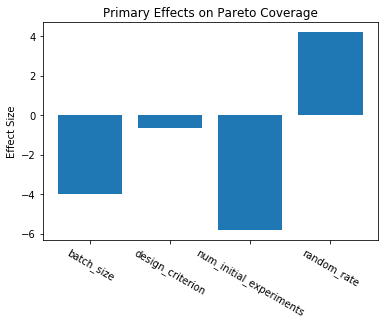

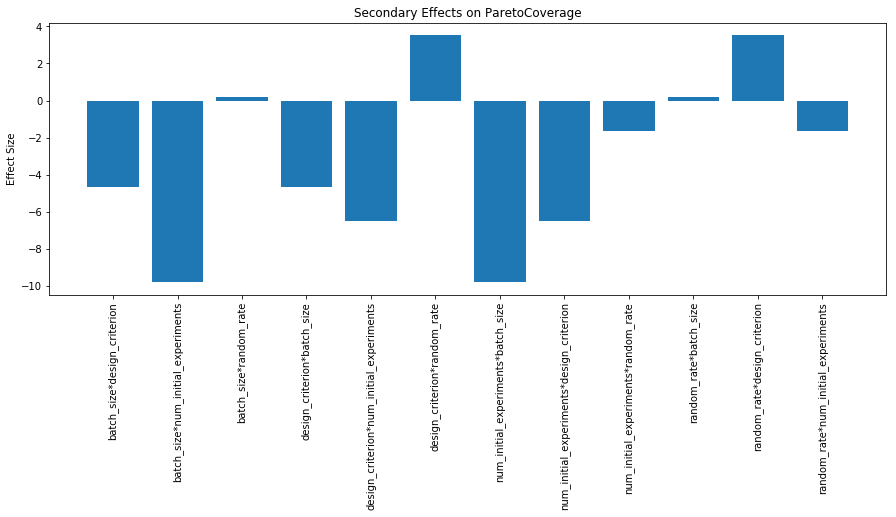

In [31]:
#Plot Pareto Coverage Effects
plt.figure()
plt.bar(np.arange(num_params), coverages_pmary_effects)
plt.xticks(np.arange(num_params), coverages_pmary_names, rotation=-30)
plt.ylabel('Effect Size')
plt.savefig('outputs/solvent_optimization_primary_effects.png', bbox_inches='tight')
plt.savefig('outputs/solvent_optimization_primary_effects.svg', bbox_inches='tight')
_ = plt.title('Primary Effects on Pareto Coverage')

plt.figure(figsize=(15,5))
ind = np.arange((num_params-1)*num_params)
plt.bar(ind, coverages_sdary_effects)
plt.ylabel('Effect Size')
plt.xticks(ind, coverages_sdary_names, rotation='vertical')
_ = plt.title('Secondary Effects on ParetoCoverage')

So, it seems that increasing the random rate significantly improves the pareto coverage. In contrast, a smaller batch size and smaller number of initial experiments actually works better. Finally, it seems the design criterion has almost no effect (which confirms my previous analysis of spatial coverage of designs).  To verify these results, let's build a ordinary least squares (OLS) linear regression model and run ANOVA to check that the effects are significant (i.e, they are statistically different from 0). I'll include a term for the interaction effect between batch size and number of initial experiments since the secondary effects plot suggests that might be significant.

In [32]:
#Create OLS linear regression model
params = {'batch_size': [4, 8],
          'design_criterion': ['center', 'maximin'],
          'num_initial_experiments': [8, 16], 
          'random_rate': [0.0, 0.5]}
levels = [len(params[key]) for key in params]
doe = fullfact(levels)
doe_repeat = np.repeat(doe, num_repeats, axis=0)
design_df = pd.DataFrame(doe_repeat, columns=[key for key in params]) 
design_df['coverages'] = coverages.flatten()
lm = ols(formula='coverages ~ batch_size + design_criterion + num_initial_experiments + random_rate + batch_size:num_initial_experiments',
         data=design_df).fit()
with open('outputs/ols_model_summary.csv', 'w') as f:
    f.write(lm.summary().as_csv())
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              coverages   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     24.29
Date:                Fri, 17 May 2019   Prob (F-statistic):           3.88e-22
Time:                        23:52:42   Log-Likelihood:                -2406.6
No. Observations:                 560   AIC:                             4825.
Df Residuals:                     554   BIC:                             4851.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             75.0510      1.851     40.543      0.000      71.415      78.687
batch_size                           -10.6122      2.138     -4.965      0.000     -14.811      -6.414
design_criterion                      -1.3265      1.511     -0.878      0.381      -4.295       1.642
num_initial_experiments              -14.2857      2.138     -6.683      0.000     -18.484     -10.087
random_rate                            8.3673      1.511      5.536      0.000       5.398      11.336
batch_size:num_initial_experiments     5.3061      3.023      1.755      0.080      -0.632      11.244
==============================================================================
Omnibus:                       22.985   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.701
Skew:                          -0.504   Prob(JB):                     4.33e-06
Kurtosis:                       3.207   Cond. No.                         7.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
#Run an ANOVA test on the coefficients
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
batch_size,1.0,8868.804665,8868.804665,27.730310,1.998764e-07
design_criterion,1.0,246.355685,246.355685,0.770286,3.805089e-01
num_initial_experiments,1.0,18944.606414,18944.606414,59.234568,6.458352e-14
random_rate,1.0,9801.749271,9801.749271,30.647371,4.782774e-08
batch_size:num_initial_experiments,1.0,985.422741,985.422741,3.081146,7.975739e-02
Residual,554.0,177182.215743,319.823494,NaN,NaN


There are two main things I'm looking for in the above print-outs.  The first is $P>|t|$ values for the coefficients. This is the p-value for a student's t-test between the each coefficient and 0.  If the p-value is small (i.e, <0.05), then we can conclude that alternative hypothesis is true (i.e., that the coefficient is significantly different than 0).  

The batch size, number of initial experiments, and random rate coefficients are significant by this measure (p<0.05). Also, as expected, the design criterion coefficient is not signficiant (p>0.05). Finally, the interaction effect might be weakly significant at the (p<0.1) level, but I think it's probably fair to say that we shouldn't read into that effect much. 

The second piece of data I examine is the ANOVA test.  Here I am again looking to see if there is a significant difference between the effects themselves.  In other words, can we distinguish the effect of batch size from that of the number of initial experiments.  Following the same logic of looking at the p values (in this case it's an F-test instead of a t-test), we can resolutely say that the effects are statistically different. 

Now, the question is why?  Why does increasing the random rate improve the pareto coverage?  And why do smaller batch sizes work better? 

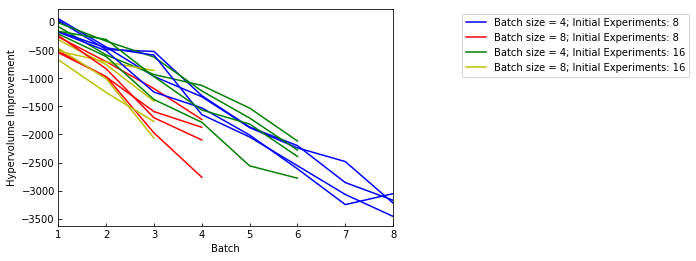

In [85]:
#Plot hypervolume over batches
ax = plt.subplot()
linestyles = ['-', '--', ':']
colors = ['b', 'g', 'r', 'y']
removed_colors = []
for i in range(num_tests):
    hvi = np.load(f"outputs/test_{i}_in_silico_hv_improvements.npy")
    mean_hvi = np.mean(hvi, axis=0)
    bs = metadata[i]['batch_size']
    nie = metadata[i]['num_initial_experiments'] 
    if bs == 4 and nie==8:
        color = colors[0]
    elif bs==4 and nie==16:
        color = colors[1]
    elif bs==8 and nie==8:
        color = colors[2]
    elif bs==8 and nie==16:
        color = colors[3]
        
    if color not in removed_colors:
        ax.plot(np.arange(1,metadata[i]['num_batches'], 1, dtype=int),
                mean_hvi,
                c=color,
                label=f"Batch size = {bs}; Initial Experiments: {nie}")
        removed_colors.append(color)
    else:
        ax.plot(np.arange(1,metadata[i]['num_batches'], 1, dtype=int),
                mean_hvi,
                c=color)

ax.set_ylabel('Hypervolume Improvement')
ax.set_xlabel('Batch')
ax.set_xticks(np.arange(1, 10, 1, dtype=int),minor=False)
ax.tick_params(direction='in')
ax.set_xlim(1,8)
ax.legend(bbox_to_anchor=(1.9,1))

plt.savefig('outputs/solvent_optimization_molecular_descriptors_hv_improvement.png')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_hv_improvement.svg')
# _ = fig.suptitle('Smaller Batch Size Improves Model Quality')
    

 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


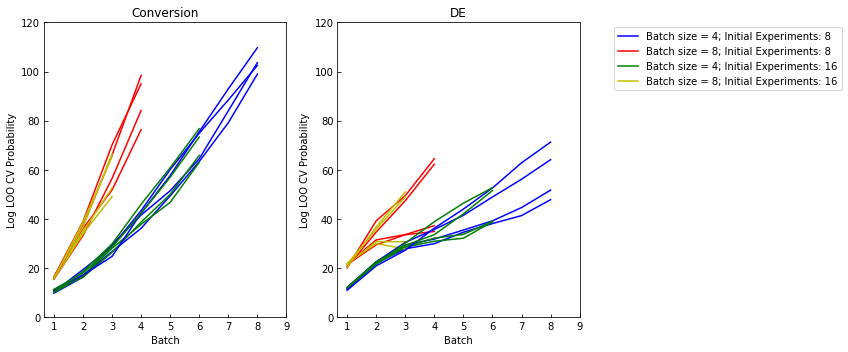

In [61]:
#Plot the log likelihood for all optimizations across batches
# to see which plots might give a good comparison
fig, axes = plt.subplots(1, 2, figsize=(12,5), tight_layout=True)
fig.subplots_adjust(hspace=0.55, wspace=0.25)
linestyles = ['-', '--', ':']
colors = ['b', 'g', 'r', 'y']
removed_colors = []
for i in range(num_tests):
    loo_errors = np.load(f"outputs/test_{i}_in_silico_loo_errors.npy")
    mean_loo_errors = np.mean(loo_errors, axis=0)
    std_dev_log_errors = np.std(loo_errors, axis=0)
    bs = metadata[i]['batch_size']
    nie = metadata[i]['num_initial_experiments'] 
    if bs == 4 and nie==8:
        color = colors[0]
    elif bs==4 and nie==16:
        color = colors[1]
    elif bs==8 and nie==8:
        color = colors[2]
    elif bs==8 and nie==16:
        color = colors[3]
        
    for j, ax in enumerate(axes):
        if color not in removed_colors and j ==1:
            ax.plot(np.arange(1,metadata[i]['num_batches'], 1, dtype=int),
                    -mean_loo_errors[:,j],
                    c=color,
                    label=f"Batch size = {bs}; Initial Experiments: {nie}")
            removed_colors.append(color)
        else:
            ax.plot(np.arange(1,metadata[i]['num_batches'], 1, dtype=int),
                    -mean_loo_errors[:,j],
                    c=color)

titles=['Conversion', 'DE']
for j, ax  in enumerate(axes):
    ax.set_ylabel('Log LOO CV Probability')
    ax.set_xlabel('Batch')
    ax.set_title(titles[j])
    ax.set_xticks(np.arange(1, 10, 1, dtype=int),minor=False)
    ax.tick_params(direction='in')
    ax.set_ylim(0, 120)
axes[1].legend(bbox_to_anchor=(2.1,1))

plt.savefig('outputs/solvent_optimization_molecular_descriptors_loo_error.png')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_loo_error.svg')
# _ = fig.suptitle('Smaller Batch Size Improves Model Quality')

 /Users/Kobi/Library/Caches/pypoetry/virtualenvs/summit-py3.6/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


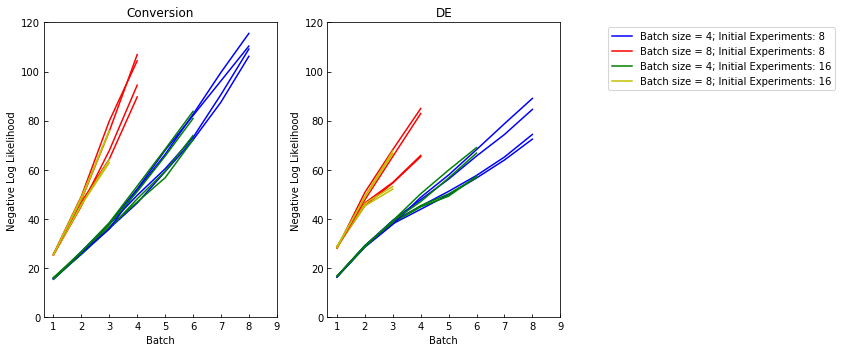

In [56]:
#Plot the log likelihood for all optimizations across batches
# to see which plots might give a good comparison
fig, axes = plt.subplots(1, 2, figsize=(12,5), tight_layout=True)
fig.subplots_adjust(hspace=0.55, wspace=0.25)
linestyles = ['-', '--', ':']
colors = ['b', 'g', 'r', 'y']
removed_colors = []
for i in range(num_tests):
    log_likelihoods = np.load(f"outputs/test_{i}_in_silico_log_likelihoods.npy")
    mean_log_likelihoods = np.mean(log_likelihoods, axis=0)
    std_dev_log_likelihoods = np.std(log_likelihoods, axis=0)
    bs = metadata[i]['batch_size']
    nie = metadata[i]['num_initial_experiments'] 
    if bs == 4 and nie==8:
        color = colors[0]
    elif bs==4 and nie==16:
        color = colors[1]
    elif bs==8 and nie==8:
        color = colors[2]
    elif bs==8 and nie==16:
        color = colors[3]
        
    for j, ax in enumerate(axes):
        if color not in removed_colors and j ==1:
            ax.plot(np.arange(1,metadata[i]['num_batches'], 1, dtype=int),
                    -mean_log_likelihoods[:,j],
                    c=color,
                    label=f"Batch size = {bs}; Initial Experiments: {nie}")
            removed_colors.append(color)
        else:
            ax.plot(np.arange(1,metadata[i]['num_batches'], 1, dtype=int),
                    -mean_log_likelihoods[:,j],
                    c=color)

titles=['Conversion', 'DE']
for j, ax  in enumerate(axes):
    ax.set_ylabel('Negative Log Likelihood')
    ax.set_xlabel('Batch')
    ax.set_title(titles[j])
    ax.set_xticks(np.arange(1, 10, 1, dtype=int),minor=False)
    ax.tick_params(direction='in')
    ax.set_ylim(0, 120)
axes[1].legend(bbox_to_anchor=(2.2,1))

plt.savefig('outputs/solvent_optimization_molecular_descriptors_log_likelihood.png')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_log_likelihood.svg')
# _ = fig.suptitle('Smaller Batch Size Improves Model Quality')

The log leave-one-out cross validation (LOO CV) probabilities also confirm that smaller initial design and batch sizes tend to result in better surrogate models.  This is especially true for the conversion model where the LOO CV probability is always larger with initial design sizes of eight instead of sixteen. Slightly larger probabilities are seen for smaller batch sizes given the same number of initial experiments. In the diasteroemeric excess model, smaller initial designs also result in higher cross validation probabilities, though the effect of initial design size is less clear likely because the random rate parameter is confounded in these plots.  Similar results were found for log likelihood.

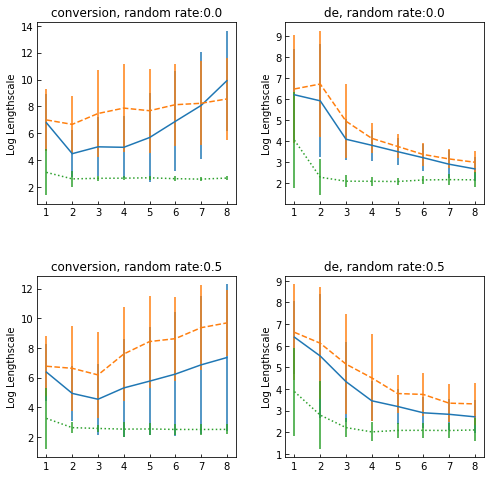

In [62]:
lengthscales = num_tests*[0]
for i in range(num_tests):
    lengthscales[i] = np.load(f"outputs/test_{i}_in_silico_lengthscales.npy")
lengthscales[0].shape      

num_components = 3
num_batches = 10

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.25)
linestyles = ['-', '--', ':']
titles = ['conversion', 'de']

#plot the lengthscales at diff random rates for the cases when there 
# are 8 initial experimets, batch size 4 and maximin criterion
for ax, test in zip(axes, [2,10]):
    l= np.average(np.log(lengthscales[test]), axis=0)
    l_std_dev = np.std(np.log(lengthscales[test]), axis=0)
    num_batches = l.shape[0]
    for i, plot in enumerate(ax):
        for j in range(num_components):
            plot.errorbar(np.arange(1, metadata[test]['num_batches'], 1, dtype=int), l[:, j, i], 
                        yerr=l_std_dev[:, j, i],
                        linestyle=linestyles[j], label=f'PC{j+1}')
        plot.set_ylabel('Log Lengthscale')
#         plot.set_xlabel('Batch')
        plot.set_title(f"{titles[i]}, random rate:{df.iloc[test]['random_rate']}")
        plot.set_xticks(np.arange(1, num_batches+1, 1, dtype=int),minor=False)
        plot.tick_params(direction='in')


### Stopping Criteria

Though the pareto coverage statistics aren't great, the algorithm does does pick several solvents, which are close to the pareto front.  The one issue is that there is a signficant amount of clustering of the solvents in one area of the output space, so there is a lot of sampling from that region. Finding some way to introduce more randomness (i.e., exploring) might be helpful.

The GP model identifies that PC<sub>1</sub> is not relevant. The problem is that PC<sub>1</sub> is usually not relevant except in a special case: when PC<sub>1</sub> is large and PC<sub>2</sub> and PC<sub>3</sub> are small. This sort of intertwined behavior might only be able to be captured by an additive or multiplicative kernel. 

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
linestyles = ['-', '--', ':']
for j, ax in enumerate(axes):
    ax.plot(np.arange(1, num_batches, 1, dtype=int), -log_likelihoods[:,j])
    ax.set_ylabel('Negative Log Likelihood')
    ax.set_xlabel('Batch')
    ax.set_title(titles[j])
    ax.set_xticks(np.arange(1, num_batches, 1, dtype=int),minor=False)
    ax.tick_params(direction='in')
fig.suptitle('Negative Log Likelihood  by Optmization Batch')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_log_likelihood.png')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_log_likelihood.svg')

SyntaxError: invalid syntax (<ipython-input-38-e5457499f7d2>, line 5)

In [ ]:
test=47
loo_errors = num_tests*[0]
for i in range(num_tests):
    loo_errors[i] = np.load(f"outputs/test_{i}_in_silico_loo_errors.npy")
fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
linestyles = ['-', '--', ':']
loo_error = np.mean(loo_errors[test], axis=0)
for j, ax in enumerate(axes):
    ax.plot(np.arange(1, metadata[test]['num_batches'], 1, dtype=int), 
            loo_error[:, j])
    ax.set_ylabel('LOO CV Error (%)')
    ax.set_xlabel('Batch')
    ax.set_title(titles[j])
    ax.tick_params(direction='in')
fig.suptitle('Leave-one-out Cross-Validation Error by Optmization Batch')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_loo_cv.png')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_loo_cv.svg')